# Аналитика Яндекс.Афиша

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Импортируем рабочие файлы

In [2]:
# df_costs = pd.read_csv('/Users/administrator/Desktop/Jupyter/update/costs (1).csv')
# df_orders = pd.read_csv('/Users/administrator/Desktop/Jupyter/update/orders_log (1).csv')
# df_visits = pd.read_csv('/Users/administrator/Desktop/Jupyter/update/visits_log_1.csv')

df_costs = pd.read_csv('/datasets/costs.csv')
df_orders = pd.read_csv('/datasets/orders_log.csv')
df_visits = pd.read_csv('/datasets/visits_log.csv')

Просмотрим файл *df_costs*

In [3]:
df_costs.sample(5)

,source_id,dt,costs
1379,4,2018-03-18,0.83
1293,4,2017-12-22,64.88
1556,5,2017-09-13,89.67
2184,10,2017-06-06,21.69
645,2,2018-03-10,109.34


In [4]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица **df_costs** (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

Просмотрим файл *df_orders*

In [5]:
df_orders.sample(5)

,Buy Ts,Revenue,Uid
23055,2017-12-09 19:08:00,3.30,2127794722036533158
43508,2018-04-08 18:55:00,4.89,473335047102617864
11883,2017-10-09 20:45:00,2.75,365173820622664624
15443,2017-10-31 11:04:00,8.55,17377546289560474746
28479,2018-01-08 06:15:00,2.93,9203010134327920270


In [6]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица **df_orders** (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

Просмотрим файл *df_visits*

In [7]:
df_visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
347555,desktop,2018-01-02 20:49:00,2,2018-01-02 20:44:00,11177822545716045840
185458,touch,2018-03-02 00:45:00,4,2018-03-02 00:42:00,8520189812062482957
338356,desktop,2017-11-16 17:24:00,3,2017-11-16 17:06:00,290489191476667666
87362,touch,2018-05-24 16:15:00,9,2018-05-24 16:11:00,9095483400029799549
249098,desktop,2017-11-24 19:35:00,1,2017-11-24 18:13:00,17758898927020866447


In [8]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица **df_visits** (лог сервера с информацией о посещениях сайта):
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

Проверим файлы на наличие дубликатов

In [9]:
df_costs.duplicated().sum()
df_orders.duplicated().sum()
df_visits.duplicated().sum()

0

Для более удобной работы с файлом *df_visits* переименуем название столбцов

In [10]:
df_visits.rename(columns={'Unnamed: 0': 'named', 
                          'Device': 'device', 
                          'End Ts': 'end_ts',
                          'Source Id': 'source_id',
                          'Start Ts': 'start_ts',
                          'Uid': 'uid'}, inplace = True)

Теперь работать с одним типом записи будет удобней

In [11]:
df_visits.sample(5)

,device,end_ts,source_id,start_ts,uid
98041,desktop,2018-03-28 03:14:00,5,2018-03-28 03:12:00,4485298274454232445
291299,desktop,2017-12-17 22:37:00,4,2017-12-17 22:25:00,10948533179188538582
243359,desktop,2017-06-20 15:11:00,3,2017-06-20 15:09:00,17548064061638883762
33614,desktop,2017-10-13 00:46:00,5,2017-10-13 00:35:00,936417777172388115
252198,touch,2017-12-28 14:13:00,4,2017-12-28 14:13:00,14683632019595284490


Переведём данные *df_visits* столбцов в нужный формат для времени

In [12]:
df_visits['end_ts'] = pd.to_datetime(df_visits['end_ts'], format ="%Y.%m.%d %H:%M")
df_visits['start_ts'] = pd.to_datetime(df_visits['start_ts'], format ="%Y.%m.%d %H:%M")

Чтобы посчитать использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату

In [13]:
df_visits['visit_day'] = df_visits['start_ts'].dt.date
df_visits['visit_week'] = df_visits['start_ts'].dt.week
df_visits['visit_month'] = df_visits['start_ts'].dt.month
df_visits['visit_year'] = df_visits['start_ts'].dt.year

Посмотрим результат вывода таблицы

In [14]:
df_visits.sample(5)

,device,end_ts,source_id,start_ts,uid,visit_day,visit_week,visit_month,visit_year
224014,touch,2018-04-22 11:47:00,5,2018-04-22 11:46:00,10132755775016295248,2018-04-22,16,4,2018
73828,touch,2018-01-05 00:48:00,4,2018-01-05 00:41:00,829391632904563695,2018-01-05,1,1,2018
84374,touch,2017-06-09 07:48:00,3,2017-06-09 07:45:00,18124720426242126138,2017-06-09,23,6,2017
343353,desktop,2018-01-07 04:11:00,1,2018-01-07 03:19:00,9500491647076530132,2018-01-07,1,1,2018
104859,desktop,2017-11-16 14:15:00,2,2017-11-16 14:04:00,10557139472070446513,2017-11-16,46,11,2017


Сгруппируем данные по уникальным пользователям и найдём среднее для daily active users

In [15]:
dau_total = df_visits.groupby('visit_day').agg({'uid': 'nunique'}).mean().round()

Видим, что показатель суточного посещения - 908

In [16]:
int(dau_total)

908

Сгруппируем данные по уникальным пользователям и найдём среднее для weekly active users

In [17]:
wau_total = df_visits.groupby(['visit_year', 'visit_week']).agg({'uid': 'nunique'}).mean().round()

Видим, что недельный показатель - 5716

In [18]:
int(wau_total)

5716

Сгруппируем данные по уникальным пользователям и найдём среднее для monthly active users

In [19]:
mau_total = df_visits.groupby('visit_month').agg({'uid': 'nunique'}).mean()

Видим, что месячный показатель - 23228

In [20]:
int(mau_total)

23228

In [21]:
mau_total

uid    23228.416667
dtype: float64

Проведём расчёт показателя sticky factor для недели

In [22]:
sticky_wau = (dau_total/wau_total) * 100

Видим, что показатель - 15.9

In [23]:
sticky_wau

uid    15.885234
dtype: float64

Проведём расчёт показателя sticky factor для месяца

In [24]:
sticky_mau = (dau_total/mau_total) * 100

Видим, что показатель - 3.9

In [25]:
sticky_mau

uid    3.909005
dtype: float64

Изучим, сколько сессий приходится на одного пользователя, сгрупировав визиты за месяц и день

In [26]:
sessions_per_user = df_visits.groupby(['visit_month', 'visit_day']).agg({'uid':['count', 'nunique']})


Переименуем столбцы

In [27]:
sessions_per_user.columns = ['n_sessions', 'n_users']

Разделим число сессий на количество пользователей за период

In [28]:
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

Один пользователь в среднем проводит чуть больше 1-ой сессии

In [29]:
sessions_per_user.sample(5)

,,n_sessions,n_users,sess_per_user
visit_month,visit_day,,,
3,2018-03-12,1293,1169,1.106074
11,2017-11-17,1538,1411,1.090007
9,2017-09-19,883,799,1.105131
10,2017-10-03,1289,1190,1.083193
7,2017-07-01,391,361,1.083102


Найдём ASL — посчитаем длину всех сессий и вычислим среднее

In [30]:
df_visits['session_duration_sec'] = (df_visits['end_ts'] - df_visits['start_ts']).dt.seconds
df_visits['session_duration_sec'].mean()

643.506488592098

Наше распределение не близко к нормальному, поэтому расчитаем моду

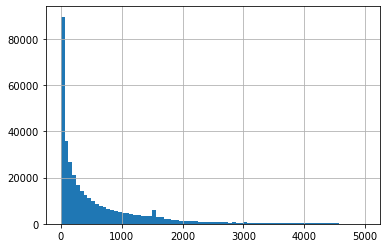

In [31]:
df_visits['session_duration_sec'].hist(bins = 80, range = (0, 5000))


In [32]:
asl = df_visits['session_duration_sec'].mode()

Видим, что мода (значение в выборке, которое встречается чаще всего) равна 60

In [33]:
asl

0    60
dtype: int64

### Retention Rate

Возьмём дату, когда пользователь впервые проявил активность

In [34]:
first_session_date_by_customers = df_visits.groupby('uid')['start_ts'].min()

In [35]:
first_session_date_by_customers.name = 'first_session_month'

In [36]:
visits1 = df_visits.join(first_session_date_by_customers,on='uid')

Переведём столбцы в нужный тип datetime64[M]

In [37]:
visits1['first_session_month'] = visits1['first_session_month'].astype('datetime64[M]')

In [38]:
visits1['session_month'] = visits1['start_ts'].astype('datetime64[M]')

Для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты

In [39]:
visits1['cohort_lifetime'] = visits1['session_month'] - visits1['first_session_month']

In [40]:
visits1['cohort_lifetime'] = visits1['cohort_lifetime'] / np.timedelta64(1,'M')

In [41]:
visits1['cohort_lifetime'] = visits1['cohort_lifetime'].round().astype('int')

Сгруппируем данные по когорте и lifetime

In [42]:
cohorts = visits1.groupby(['first_session_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю

In [43]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_month', 'uid']]

In [44]:
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте

In [45]:
cohorts = cohorts.merge(initial_users_count, on='first_session_month')

Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте

In [46]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [47]:
retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')

In [48]:
retention_pivot.round(3).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.079,0.054,0.061,0.069,0.071,0.061,0.058,0.052,0.051,0.041,0.045
2017-07-01,1.0,0.056,0.051,0.056,0.058,0.048,0.045,0.046,0.039,0.029,0.027,
2017-08-01,1.0,0.077,0.063,0.063,0.05,0.044,0.036,0.039,0.028,0.026,,
2017-09-01,1.0,0.085,0.069,0.051,0.039,0.038,0.036,0.024,0.023,,,
2017-10-01,1.0,0.079,0.052,0.039,0.034,0.032,0.021,0.02,,,,
2017-11-01,1.0,0.078,0.044,0.039,0.034,0.023,0.022,,,,,
2017-12-01,1.0,0.056,0.038,0.031,0.02,0.019,,,,,,
2018-01-01,1.0,0.06,0.039,0.025,0.02,,,,,,,
2018-02-01,1.0,0.057,0.025,0.02,,,,,,,,


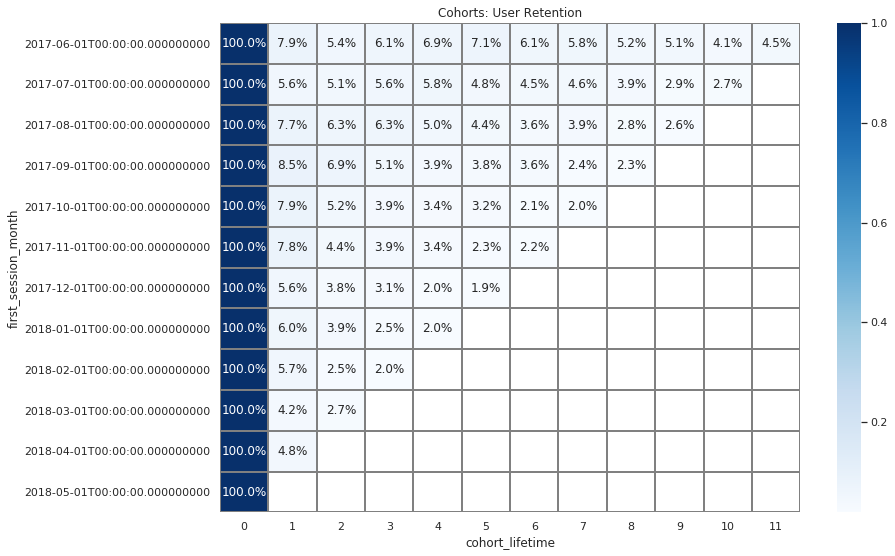

In [49]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap = 'Blues');

### Изучим продажи

Изучим файл *df_orders*

In [50]:
df_orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


Переименуем столбцы для более удобной работы

In [51]:
df_orders.rename(columns={'Unnamed: 0': 'named', 
                          'Buy Ts': 'buy_ts', 
                          'Revenue': 'revenue',
                          'Uid': 'uid'}, inplace = True)

Посмотрим столбцы

In [52]:
df_orders.sample(5)

,buy_ts,revenue,uid
26235,2017-12-26 17:09:00,2.44,4435931324057795549
45957,2018-04-29 13:39:00,7.82,2907159537784984698
41643,2018-03-25 07:40:00,0.44,1696674919164997679
5181,2017-08-11 12:24:00,0.85,1689785186224179658
31483,2018-01-28 18:13:00,2.93,7357895473102531043


Переведём столбец со временем в нужный тип

In [53]:
df_orders['buy_ts'] = pd.to_datetime(df_orders['buy_ts'], format ="%Y.%m.%d %H:%M")



In [54]:
first_order_date_by_customers = df_orders.groupby('uid')['buy_ts'].min() 


Просмотрим результат

In [55]:
first_order_date_by_customers.sample(5)

uid
402880731712871855    2017-09-07 22:09:00
4112000166055013800   2017-12-26 16:43:00
5591931657833998998   2018-04-07 11:40:00
8409001743276203013   2018-02-02 19:50:00
5995674724016678055   2017-11-29 11:49:00
Name: buy_ts, dtype: datetime64[ns]

Изменим имя Series на first_order_date, обратившись к атрибуту name у Series

In [56]:
first_order_date_by_customers.name = 'first_order_date'

Методом join() объединим датафрейм df_orders и Series first_order_date_by_customers по столбцу 'uid' в датафрейм orders

In [57]:
orders = df_orders.join(first_order_date_by_customers,on='uid')


In [58]:
first_order_date_by_customers

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: first_order_date, Length: 36523, dtype: datetime64[ns]

Посмотрми на результат

In [59]:
orders.sample(5)

,buy_ts,revenue,uid,first_order_date
10481,2017-10-04 09:11:00,0.55,2355117916482869091,2017-10-04 09:11:00
37738,2018-03-02 13:12:00,3.67,10805119391862435819,2018-03-02 13:12:00
33587,2018-02-08 16:20:00,1.83,6774496153642655881,2018-02-08 16:20:00
14069,2017-10-22 20:12:00,2.08,16507828257613250154,2017-10-22 20:12:00
27893,2018-01-03 17:20:00,1.83,1850478907071365512,2017-10-26 11:20:00


Вызовем метод astype() и преобразуем значения столбцов к типу 'datetime64[M]'

In [60]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [61]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')


Посмотрим на результат

In [62]:
orders.sample(5)

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
36446,2018-02-22 17:28:00,4.89,15468122609603359988,2018-02-22 17:28:00,2018-02-01,2018-02-01
10860,2017-10-05 16:57:00,6.61,16198092435581042108,2017-10-05 16:57:00,2017-10-01,2017-10-01
4795,2017-08-02 20:30:00,0.61,7358976485213746170,2017-06-05 01:35:00,2017-06-01,2017-08-01
27697,2018-01-02 16:07:00,2.44,3711710598491146509,2018-01-02 16:07:00,2018-01-01,2018-01-01
42018,2018-03-26 12:48:00,3.05,4536413950946237341,2018-03-26 12:48:00,2018-03-01,2018-03-01


Сгруппируем данные по этому столбцу и оценим показатели каждой когорты

In [63]:
cohort_grouped = orders.groupby('first_order_month').agg({'uid':'nunique',
                                                          'revenue':'sum'})

In [64]:
cohort_grouped

,uid,revenue
first_order_month,,
2017-06-01,2023,24031.69
2017-07-01,1923,16127.92
2017-08-01,1370,11606.26
2017-09-01,2581,34676.32
2017-10-01,4340,27603.45
2017-11-01,4081,26098.99
2017-12-01,4383,33485.74
2018-01-01,3373,16663.13
2018-02-01,3651,16750.50


### Оценка изменений абсолютных показателей по месяцам

Отследис, как изменяется количество покупающих пользователей внутри одной когорты. Это позволит понять, сколько людей продолжают покупать в следующих месяцах после совершения первой покупки. 

In [65]:
orders.pivot_table(index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='nunique').fillna('')


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2023,61,50,54,88,67,62,47,58,45,45,53,
2017-07-01,,1923,52,57,64,49,38,36,39,42,22,26,
2017-08-01,,,1370,58,53,44,40,32,30,44,19,31,
2017-09-01,,,,2581,130,100,74,52,64,66,37,43,
2017-10-01,,,,,4340,206,123,92,93,72,56,67,
2017-11-01,,,,,,4081,222,120,106,81,48,62,
2017-12-01,,,,,,,4383,146,103,97,50,63,
2018-01-01,,,,,,,,3373,114,83,43,45,
2018-02-01,,,,,,,,,3651,118,58,39,


Сгруппируем данные по когорте first_order_month и месяцу совершения заказа order_month

In [66]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})

In [67]:
orders_grouped_by_cohorts

revenue   uid
first_order_month order_month                
2017-06-01        2017-06-01    9557.49  2023
                  2017-07-01     981.82    61
                  2017-08-01     885.34    50
                  2017-09-01    1931.30    54
                  2017-10-01    2068.58    88
...                                 ...   ...
2018-03-01        2018-05-01    1114.87    58
2018-04-01        2018-04-01   10600.69  2276
                  2018-05-01    1209.92    69
2018-05-01        2018-05-01   13925.76  2988
2018-06-01        2018-06-01       3.42     1

[79 rows x 2 columns]

In [68]:
orders_grouped_by_cohorts.pivot_table(index = 'first_order_month', 
                                      values = 'revenue', 
                                      aggfunc = 'sum')

,revenue
first_order_month,
2017-06-01,24031.69
2017-07-01,16127.92
2017-08-01,11606.26
2017-09-01,34676.32
2017-10-01,27603.45
2017-11-01,26098.99
2017-12-01,33485.74
2018-01-01,16663.13
2018-02-01,16750.50


Найдём средний чек покупателя revenue_per_user — разделим показатель revenue на uid

In [69]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени

In [70]:
orders_grouped_by_cohorts.pivot_table(index='first_order_month', 
                                      columns='order_month', 
                                      values='revenue_per_user',
                                      aggfunc='mean').fillna('')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.72441,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415,
2017-07-01,,6.01022,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,
2017-08-01,,,5.27652,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,
2017-09-01,,,,5.64453,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,
2017-10-01,,,,,5.00373,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,
2017-11-01,,,,,,5.15468,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,
2017-12-01,,,,,,,4.73819,7.81658,39.366,48.1351,27.4314,23.5184,
2018-01-01,,,,,,,,4.13564,8.72123,12.3655,11.1998,4.69956,
2018-02-01,,,,,,,,,4.15699,8.61,4.94241,6.94103,


Оценим, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки - *lifetime*

In [71]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()

Найдём lifetime когорты. Из месяца совершения заказа order_month вычтем месяц когорты first_order_month

In [72]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']

In [73]:
orders_grouped_by_cohorts['cohort_lifetime'].head()

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

Преобразуем тип данных в число месяцев, прошедших между датами. 

In [74]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

Приведём к целочисленному типу методом astype('int')

In [75]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [76]:
print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].head())

  first_order_month order_month  cohort_lifetime
0        2017-06-01  2017-06-01                0
1        2017-06-01  2017-07-01                1
2        2017-06-01  2017-08-01                2
3        2017-06-01  2017-09-01                3
4        2017-06-01  2017-10-01                4


In [77]:
print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].tail())

   first_order_month order_month  cohort_lifetime
74        2018-03-01  2018-05-01                2
75        2018-04-01  2018-04-01                0
76        2018-04-01  2018-05-01                1
77        2018-05-01  2018-05-01                0
78        2018-06-01  2018-06-01                0


Применим метод dt.strftime() и превратим объект Series с типом datetime в строку в формате даты

In [78]:
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y.%m.%d')

0     2017.06.01
1     2017.06.01
2     2017.06.01
3     2017.06.01
4     2017.06.01
         ...    
74    2018.03.01
75    2018.04.01
76    2018.04.01
77    2018.05.01
78    2018.06.01
Name: first_order_month, Length: 79, dtype: object

Оставим в данных о месяце первого заказа только год и месяц

In [79]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты

In [80]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')


In [81]:
revenue_per_user_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415
2017-07,6.010218,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,
2017-08,5.276518,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,,
2017-09,5.644529,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,,,
2017-10,5.003733,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,,,,
2017-11,5.154683,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,,,,,
2017-12,4.738191,7.81658,39.366,48.1351,27.4314,23.5184,,,,,,
2018-01,4.135636,8.72123,12.3655,11.1998,4.69956,,,,,,,
2018-02,4.156987,8.61,4.94241,6.94103,,,,,,,,


Создадим тепловую карту методом heatmap() и передадим ей сводную таблицу revenue_per_user_pivot

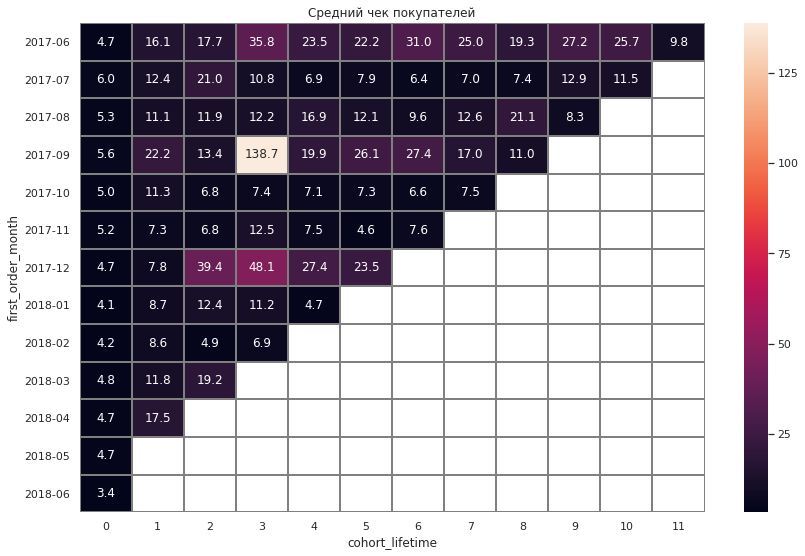

In [82]:
plt.figure(figsize=(14, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')


Выводы по таблице:
* На общем фоне особенно выделяется сентябрьская когорта за 3 месяц, там средний чек достиг отметки в 138,7
* Так же переодические всплески среднего чека наблюдаются у когорт за декабрь, июнь, сентябрь
* Есть определенная череда одинаковых всплесков у когорт за сентябрь и декабрь
> Важно понимать, что такие всплески могут быть (и скорее всего) вызваны малым числом покупателей, т.е. являются выбросами.

### Изучим маркетинг

Изучим файл *df_costs*

In [83]:
df_costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


Переведём столбец *dt* во временной формат

In [84]:
df_costs['month'] = df_costs['dt'].astype('datetime64[M]')

Получим месяц первой покупки каждого покупателя

In [85]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()

In [86]:
first_orders.columns = ['uid', 'first_order_month']

In [87]:
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей (n_buyers) за каждый месяц

In [88]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()

In [89]:
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [90]:
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Добавим месяц первой покупки каждого покупателя в таблицу с заказами

In [91]:
orders_new = pd.merge(orders, first_orders, on='uid')


In [92]:
orders_new.head()

,buy_ts,revenue,uid,first_order_date,first_order_month_x,order_month,first_order_month_y
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01


In [93]:
orders_new.drop(['first_order_month_y'], axis='columns', inplace=True)

In [94]:
orders_new

,buy_ts,revenue,uid,first_order_date,first_order_month_x,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку

In [95]:
cohorts = orders_new.groupby(['first_order_month_x','order_month']).agg({'revenue': 'sum'}).reset_index()


In [96]:
cohorts.columns = ['first_order_month', 'orders_month', 'revenue']

In [97]:
cohorts.head()

,first_order_month,orders_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц

In [98]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [99]:
report.head()

,first_order_month,n_buyers,orders_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Найдем валовую прибыль, умножив выручку на маржинальность, так как в задании не указано какая маржинальность, то оставим её как - 1.

А так же найдем относительный показатель по «возрастным» когортам, где в столбцах возраст (age) когорты

In [100]:
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['orders_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,orders_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте

In [101]:
report['ltv'] = report['revenue'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
    
report_output = output.iloc[:6, :6].fillna('')

In [102]:
report_output

age,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,4.724,0.485,0.438,0.955,1.023,0.736
2017-07-01,6.010,0.335,0.624,0.359,0.177,0.156
2017-08-01,5.277,0.472,0.458,0.391,0.494,0.284
2017-09-01,5.645,1.118,0.521,3.976,0.401,0.647
2017-10-01,5.004,0.536,0.191,0.157,0.152,0.120
2017-11-01,5.155,0.399,0.200,0.325,0.148,0.054


Как видим по усредненной когорте, то лучше всех показывают себя *2017-09-01*, *2017-06-01*

Посчитаем итоговый LTV первой когорты. Сложим их LTV по месяцам

Теперь посчитаем за весь период

In [103]:
ltv_170601 = output.loc['2017-06-01'].sum()

В среднем каждый покупатель из первой когорты принес по 8 

In [104]:
ltv_170601

11.88

Посчитаем CAC этой когорты. Поделим расходы за этот месяц на количество людей в когорте

In [105]:
costs_170601 = df_costs[df_costs['month'] == '2017-06-01']['costs'].sum()

In [106]:
costs_170601

18015.0

In [107]:
# отфильруем нужную когорту
cohort_170601 = report[report['first_order_month'] == '2017-06-01']

# посчитаем расходы за этот месяц
costs_170601 = df_costs[df_costs['month'] == '2017-06-01']['costs'].sum()

n_buyers_170601 = cohort_170601['n_buyers'][0]
cac_170601 = costs_170601 / n_buyers_170601
ltv_170601 = output.loc['2017-06-01'].sum()

print('CAC =', cac_170601)
print('LTV =', ltv_170601)



CAC = 8.905091448344043
LTV = 11.88


Привлечение одного покупателя в среднем обошлось компании в 8.9, а валовая прибыль с каждого из них: 11.9.

Посчитаем, сколько тратили бюджета в месяц на каждый источник

In [108]:
df_costs.pivot_table(index = 'source_id',columns = 'month', values = 'costs', aggfunc = 'sum')

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


Отсортируем визиты по сессиям

In [109]:
df_new = df_visits.sort_values(by = 'start_ts')

Найдем источник первой сессии

In [110]:
first_source_per_user = df_new.groupby('uid').agg({'source_id': 'first'})


Объеденим таблицы продаж и источником первой сессии

In [111]:
client_per_source = orders.merge(first_source_per_user, on='uid')


Найдем общее количество покупателей по источнику

In [112]:
client_per_source_n = client_per_source.groupby('source_id').agg({'uid': 'nunique'})


In [113]:
client_per_source_n

,uid
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


Объеденим таблицы продаж и покупателями

In [114]:
visits_orders = df_visits[df_visits['uid'].isin(orders['uid']) == True]



In [115]:
visits_orders = visits_orders[['device', 'end_ts', 'source_id', 'start_ts', 'uid']]



In [116]:
visits_orders = visits_orders.sort_values(by = 'start_ts')



In [117]:
orders_plus_visits = pd.merge(orders, visits_orders, on = 'uid')
orders_plus_visits.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,device,end_ts,source_id,start_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00


In [118]:
orders_plus_visits['session_month'] = orders_plus_visits['start_ts'].astype('datetime64[M]')


Найдем прибыль с каждого источника

In [119]:
x = (client_per_source
    .pivot_table(index = ['first_order_month', 'order_month', 'source_id'], values = ['revenue'], aggfunc = 'sum')
    .reset_index())
x.head()

,first_order_month,order_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1378.70
1,2017-06-01,2017-06-01,2,1043.68
2,2017-06-01,2017-06-01,3,2804.34
3,2017-06-01,2017-06-01,4,1959.84
4,2017-06-01,2017-06-01,5,1898.89


In [120]:
x.sum()

source_id      2345.0
revenue      252057.2
dtype: float64

Найдем затраты на каждый источник

In [121]:
df_costs['order_month'] = df_costs['dt'].astype('datetime64[M]')
cost_source = df_costs.groupby(['source_id', 'month', 'order_month']).agg({'costs': 'sum'}).reset_index()
cost_source = cost_source.rename(columns = ({'month': 'first_order_month'}))
cost_source.head()

,source_id,first_order_month,order_month,costs
0,1,2017-06-01,2017-06-01,1125.61
1,1,2017-07-01,2017-07-01,1072.88
2,1,2017-08-01,2017-08-01,951.81
3,1,2017-09-01,2017-09-01,1502.01
4,1,2017-10-01,2017-10-01,2315.75


Объеденим таблицы первого источника первого захода и покупки с визитами

In [122]:
var_1 = pd.merge(orders_plus_visits, first_source_per_user, on = ['uid', 'source_id'])
var_1 = var_1.rename(columns = ({'source_id': 'first_session'}))
var_1.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,device,end_ts,first_session,start_ts,session_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017-06-01


Посчитаем количество покупателей по месяцам и источнику

In [123]:
var_1_new = var_1.groupby(['first_session', 'first_order_month', 'order_month']).agg({'uid': 'nunique'}).reset_index()
var_1_new = var_1_new.rename(columns = ({'first_session': 'source_id'}))
var_1_new.head()

,source_id,first_order_month,order_month,uid
0,1,2017-06-01,2017-06-01,190
1,1,2017-06-01,2017-07-01,16
2,1,2017-06-01,2017-08-01,10
3,1,2017-06-01,2017-09-01,9
4,1,2017-06-01,2017-10-01,12


Объеденим таблицы затрат и покупателей

In [124]:
var_1_new = pd.merge(cost_source, var_1_new, on = ['first_order_month', 'order_month', 'source_id'])
var_1_new.head()

,source_id,first_order_month,order_month,costs,uid
0,1,2017-06-01,2017-06-01,1125.61,190
1,1,2017-07-01,2017-07-01,1072.88,160
2,1,2017-08-01,2017-08-01,951.81,113
3,1,2017-09-01,2017-09-01,1502.01,227
4,1,2017-10-01,2017-10-01,2315.75,340


Объёденим таблицы с затратами по первому месяцу покупки, месяцу покупки и источнику

In [125]:
proba_n =  pd.merge(var_1_new, x, on = ['first_order_month', 'order_month', 'source_id'], how = 'outer')
proba_n

,source_id,first_order_month,order_month,costs,uid,revenue
0,1,2017-06-01,2017-06-01,1125.61,190.0,1378.70
1,1,2017-07-01,2017-07-01,1072.88,160.0,1166.70
2,1,2017-08-01,2017-08-01,951.81,113.0,846.75
3,1,2017-09-01,2017-09-01,1502.01,227.0,1365.34
4,1,2017-10-01,2017-10-01,2315.75,340.0,2046.33
...,...,...,...,...,...,...
511,3,2018-04-01,2018-05-01,NaN,NaN,875.44
512,4,2018-04-01,2018-05-01,NaN,NaN,134.58
513,5,2018-04-01,2018-05-01,NaN,NaN,30.81
514,9,2018-04-01,2018-05-01,NaN,NaN,23.83


In [126]:
proba_n.sum()

source_id      2345.00
costs        329131.62
uid           36521.00
revenue      252057.20
dtype: float64

Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте

In [127]:
proba_n['ltv'] = proba_n['revenue'] / proba_n['uid']
    
output = proba_n.pivot_table(
        index='first_order_month', 
        columns='source_id', 
        values='ltv', 
        aggfunc='mean').round(3)
    
output.iloc[:, :].fillna('')

source_id,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,7.256,4.441,4.396,4.745,4.945,3.569,2.414
2017-07-01,7.292,8.430,6.105,5.545,5.287,4.469,3.461
2017-08-01,7.493,5.739,5.079,5.065,5.050,4.075,4.997
2017-09-01,6.015,8.282,5.563,4.767,6.196,4.297,2.234
2017-10-01,6.019,7.676,4.787,4.368,5.091,5.064,2.619
2017-11-01,7.391,6.989,4.532,5.144,4.560,3.739,4.622
2017-12-01,4.584,8.809,4.179,4.172,5.007,3.826,3.791
2018-01-01,5.769,4.343,4.114,3.782,4.352,2.834,3.099
2018-02-01,4.687,5.417,3.788,4.093,4.322,4.801,2.474


Посчитаем CAC этой когорты. Поделим расходы за этот месяц на количество людей в когорте

In [128]:
proba_n['cac'] = proba_n['costs'] / proba_n['uid']
    
output = proba_n.pivot_table(
        index='first_order_month', 
        columns='source_id', 
        values='cac', 
        aggfunc='mean').round(3)
    
output.iloc[:, :].fillna('')

source_id,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,5.924,10.329,12.119,8.510,6.813,4.194,3.308
2017-07-01,6.705,11.217,14.989,6.827,7.088,5.818,6.467
2017-08-01,8.423,14.724,18.230,9.519,6.070,4.081,6.286
2017-09-01,6.617,13.510,12.757,8.800,6.535,4.777,5.357
2017-10-01,6.811,12.235,13.661,5.479,6.103,4.837,3.001
2017-11-01,7.547,13.185,14.001,4.578,9.127,4.712,6.190
2017-12-01,7.073,12.855,12.316,5.578,7.617,5.438,7.598
2018-01-01,9.186,14.239,14.720,5.652,8.486,6.839,6.678
2018-02-01,8.016,15.271,13.030,5.165,7.480,6.565,3.910


Посчитаем ROI этой когорты. Отнимем от прибыли затраты и поделим на затраты

In [129]:
proba_n['roi'] = (proba_n['revenue'] - proba_n['costs'])/proba_n['costs']

output_roi = proba_n.pivot_table(
        index='first_order_month', 
        columns='source_id', 
        values='roi', 
        aggfunc='mean').round(3)
    
output_roi.iloc[:, :].fillna('')



source_id,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,0.225,-0.570,-0.637,-0.442,-0.274,-0.149,-0.270
2017-07-01,0.087,-0.248,-0.593,-0.188,-0.254,-0.232,-0.465
2017-08-01,-0.110,-0.610,-0.721,-0.468,-0.168,-0.001,-0.205
2017-09-01,-0.091,-0.387,-0.564,-0.458,-0.052,-0.101,-0.583
2017-10-01,-0.116,-0.373,-0.650,-0.203,-0.166,0.047,-0.127
2017-11-01,-0.021,-0.470,-0.676,0.123,-0.500,-0.206,-0.253
2017-12-01,-0.352,-0.315,-0.661,-0.252,-0.343,-0.296,-0.501
2018-01-01,-0.372,-0.695,-0.720,-0.331,-0.487,-0.586,-0.536
2018-02-01,-0.415,-0.645,-0.709,-0.207,-0.422,-0.269,-0.367


Посчитаем средние значения для источников по 'ltv', 'roi', 'cac'

In [130]:
fin_1 = proba_n.pivot_table(index = 'source_id', 
                    values = ['ltv', 'roi', 'cac'], 
                    aggfunc = 'mean').round(3)


Посчитаем суммарные показатели для источников по 'revenue', 'costs', 'uid'

In [131]:
fin_2 = proba_n.pivot_table(index = 'source_id', 
                    values = ['revenue', 'costs', 'uid'], 
                    aggfunc = 'sum').round(3)

Выведим финальную таблицу

In [132]:
fin = pd.merge(fin_1, fin_2, on = 'source_id', how = 'outer')
fin

,cac,ltv,roi,costs,revenue,uid
source_id,,,,,,
1,7.212,6.314,-0.107,20833.27,31090.55,2899.0
2,12.504,6.502,-0.451,42806.04,46923.61,3506.0
3,13.803,4.606,-0.664,141321.63,54511.24,10473.0
4,6.439,4.667,-0.243,61073.60,56696.83,10295.0
5,7.452,4.835,-0.335,51757.10,52624.02,6931.0
9,5.414,4.008,-0.226,5517.49,5759.40,1088.0
10,4.867,3.268,-0.273,5822.49,4450.33,1329.0
7,NaN,NaN,NaN,0.00,1.22,0.0


Видим, что самым перспективным можно назвать 1, 9, 4 и 10 источники, самым слабым можно назвать 3 источник.

# Выводы

Исходя из расчётов, которые были сделаны - можно сказать:

    * оказатель суточного посещения - 908
    * недельный показатель - 5716
    * месячный показатель - 23228
    * sticky_wau - 15.9
    * sticky_mau - 3.9
    * Asl - 60
    * В среднем пользователь проводит чуть больше 1-ой сессии
    * На второй месяц после первой покупки пользователи крайне редко возвращаются для повторной покупки
    * Почти во всех когортах повторные покупки происходят почти в одинаковом количестве
    * На общем фоне особенно выделяется сентябрьская когорта за 3 месяц, там средний чек достиг отметки в 138,7
    * Так же переодические всплески среднего чека наблюдаются у когорт за декабрь, июнь, сентябрь
    *  Самым перспективным можно назвать 1, 9, 4 и 10 источники, самым слабым можно назвать 3 источник.